In [2]:
import torch
from torch import nn
from torch import optim
from torchvision import transforms
from torchvision import datasets

import numpy as np
from PIL import Image
import os

In [3]:
#images = open('handwritten_digits_images.csv','r').readlines()

image_array = np.genfromtxt('handwritten_digits_images.csv',delimiter=',').astype(np.uint8)
label_array = np.genfromtxt('handwritten_digits_labels.csv').astype(np.uint8)

In [4]:
image_array_length = len(image_array)
label_array_length = len(label_array)

print(f"Same size arrays: {image_array_length == label_array_length}")
print(f"Array length: {image_array_length}")


Same size arrays: True
Array length: 70000


In [5]:


def partitiondata(label_array=label_array, image_array=image_array, seed = 42):
    np.random.seed(2021)
    start = 0
    end = 0
    
    # Counting number of each label/digit
    labels_count = {}
    for i in label_array:
        count = labels_count.get(i,0)
        count += 1
        labels_count[i] = count
    
    
    # Partitions the image_array based on the counts calculated above
    partitions = []
    for count in labels_count.values():
        end += count
        
        section = image_array[start:end].copy()   # "Copy" used to prevent shuffling the entire array (Should be consistent based on seed)
        np.random.shuffle(section)
        
        train_count = int(count*0.7)          # 70% train
        val_test_count = count - train_count
        val_count = int(val_test_count * 0.5) # 15% val 15% test
        test_count = val_test_count - val_count
        
        train_X = section[:train_count]
        val_X = section[train_count:train_count + val_count]
        test_X = section[train_count+val_count:]
        
        partitions.append((train_X,val_X,test_X))
        
        start += count
        
    return partitions
        
        
def writeImages(partitioned_data):
    
    # File structure generation
    
    outer_folders = ['train','val','test']
    inner_folders = list(map(str, list(range(10))))

    if not os.path.exists('MNIST'):
        os.makedirs('MNIST')

    for outer in outer_folders:
        for inner in inner_folders:
            if not os.path.exists('MNIST/' + outer + '/' + inner):
                os.makedirs('MNIST/' + outer + '/' + inner)
    
    
    # Image generation
    
    for outer_idx, outer in enumerate(outer_folders):
        for inner in inner_folders:
            name = 0
            for image in partitioned_data[int(inner)][outer_idx]:
                my_image = Image.fromarray(image.astype(np.int8).reshape(28,28)).convert('RGB')
                my_image.save('MNIST/'+outer+'/'+inner+ '/' + str(name) +'.jpeg')
                
                name += 1
                

        
#writeImages(partitiondata())

print(len(partitiondata()))

10


In [5]:

preprocessor = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Pad(padding=2),
    transforms.ToTensor()
])


In [6]:

train_dataset= datasets.ImageFolder(root="./MNIST/train",transform=preprocessor)
test_dataset = datasets.ImageFolder(root="./MNIST/test",transform=preprocessor)
val_dataset  = datasets.ImageFolder(root="./MNIST/val", transform=preprocessor)




batch_size = 32

training_generator = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_generator = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)
test_generator = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)


In [7]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

In [8]:
import torch.nn as nn
import torch.nn.functional as F


image_width_height = 32
input_size = 1024
hid1 = 1024
hid2 = 512
hid3 = 256
output_size = 10


class Network(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, num_classes):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2_size, hidden3_size)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden3_size, output_size)
    
    def forward(self, x):
        out = x.view(-1, image_width_height*image_width_height)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        return out



# define the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(image_width_height*image_width_height, hid1)
        self.fc2 = nn.Linear(hid1, hid2)
        self.fc3 = nn.Linear(hid2, hid3)
        self.fc4 = nn.Linear(hid3, output_size)

    def forward(self, x):
        x = x.view(-1, image_width_height*image_width_height)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x



'''
Chose to go with the model definition from the hint in the assignment.
'''
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

model = torch.nn.Sequential(
    Lambda(lambda x : x.view(-1,image_width_height*image_width_height)), # Flatten image
    nn.Linear(input_size, hid1),
    nn.ReLU(),
    nn.Linear(hid1, hid2),
    nn.ReLU(),
    nn.Linear(hid2, hid3),
    nn.ReLU(),
    nn.Linear(hid3, output_size),
).to(dev)



In [9]:
print('''
So i found a few different ways to construct the network and its structure. And in my (incomprehensive) testing i found
no particular performance difference. So im guessing building the model from scrath so to speak offers more flexibility
in how the layers interact whereas a model constructed with the sequential function is quick and easy.

A little about the model:
I chose to go with the ReLU activation function and three hidden layers with decreasing hidden units deeper in the network.
There is no particular logic behind this other than it intuitively makes sense to gradually decrease the layer-sizes.
And I got pretty great results very quickly in training. Consistently improves to almost 90% accuracy in the first 3 epochs.
''')


So i found a few different ways to construct the network and its structure. And in my (incomprehensive) testing i found
no particular performance difference. So im guessing building the model from scrath so to speak offers more flexibility
in how the layers interact whereas a model constructed with the sequential function is quick and easy.

A little about the model:
I chose to go with the ReLU activation function and three hidden layers with decreasing hidden units deeper in the network.
There is no particular logic behind this other than it intuitively makes sense to gradually decrease the layer-sizes.
And I got pretty great results very quickly in training. Consistently improves to almost 90% accuracy in the first 3 epochs.



In [10]:
history = {}

lr = 0.01
momentum = 0.9
loss_func = nn.CrossEntropyLoss()
opt = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

def train_model(model, loss_func=loss_func, opt=opt, momentum=momentum, lr=lr, history=history, epochs = 25):
    min_validation_loss = np.Inf
    
    history['training_loss']    = {}
    history['validation_loss'] = {}
    history['training_acc']     = {}
    history['validation_acc']  = {}
    
    
    for epoch in range(epochs):
        print(f"Epoch {epoch+1} begins...")
        print(f"    Training begins...")
        
        
        ###   Training   ###
        epoch_training_loss     = 0.0
        epoch_training_accuracy = 0.0
        
        
        model.train()
        for data, target in training_generator:
            data, target = data.to(dev), target.to(dev)

            
            pred = model(data)
            loss = loss_func(pred, target)
            loss.backward()# backprop
            opt.step()     # updates
            opt.zero_grad()# resets gradient
            
            current_batch_training_loss = loss.item()*data.size(0)
            epoch_training_loss += current_batch_training_loss
            
            # Calculate accuracy
            _, pred_ = torch.max(pred, 1)
            correct = np.squeeze(pred_.eq(target.data.view_as(pred_)))
            current_batch_training_accuracy = correct.sum().item()
            epoch_training_accuracy += current_batch_training_accuracy
            
            # Save history
            training_loss_history = history['training_loss'].get(epoch+1, [])
            training_loss_history.append(current_batch_training_loss / data.size(0))
            history['training_loss'][epoch+1] = training_loss_history
            
            training_accuracy_history = history['training_acc'].get(epoch+1, [])
            training_accuracy_history.append(current_batch_training_accuracy / data.size(0))
            history['training_acc'][epoch+1] = training_accuracy_history
 
        
        # Print current epoch total accuracy and loss
        epoch_training_accuracy = epoch_training_accuracy / len(training_generator.dataset)
        epoch_training_loss = epoch_training_loss / len(training_generator.dataset)
        
        print(f"    - Epoch training loss: {np.round(epoch_training_loss, decimals=5)}")
        print(f"    - Epoch training accuracy: {np.round(epoch_training_accuracy, decimals=5)}")



        ###   Validation   ###
        epoch_validation_loss     = 0.0
        epoch_validation_accuracy = 0.0
    
        model.eval()
        
        print(f"    Validation begins...")
        with torch.no_grad():  # Disable autograd
            for data, target in validation_generator:
                data, target = data.to(dev), target.to(dev)
                pred = model(data)

                loss = loss_func(pred,target)
                current_batch_validation_loss = loss.item()*data.size(0)
                epoch_validation_loss += current_batch_validation_loss
                
                # Calculate accuracy
                _, pred_ = torch.max(pred, 1)
                current_batch_validation_accuracy = np.squeeze(pred_.eq(target.data.view_as(pred_))).sum().item()
                epoch_validation_accuracy += current_batch_validation_accuracy
                
                validation_loss_history = history['validation_loss'].get(epoch+1, [])
                validation_loss_history.append(current_batch_validation_loss / data.size(0))
                history['validation_loss'][epoch+1] = validation_loss_history
                
                validation_acc_history = history['validation_acc'].get(epoch+1, [])
                validation_acc_history.append(current_batch_validation_accuracy / data.size(0))
                history['validation_acc'][epoch+1] = validation_acc_history
                

            epoch_validation_loss = epoch_validation_loss / len(validation_generator.dataset)
            epoch_validation_accuracy = epoch_validation_accuracy / len(validation_generator.dataset)
            #history['validation_loss'].append(validation_loss)
            #history['validation_acc'].append(validation_accuracy)
            
            print(f"    - Epoch validation loss: {np.round(epoch_validation_loss, decimals=5)}")
            print(f"    - Epoch validation accuracy: {np.round(epoch_validation_accuracy, decimals=5)}")
            
            
            if epoch_validation_loss <= min_validation_loss:
                print("    " + 40*"-")
                print(f"    - New lowest validation loss: {np.round(epoch_validation_loss, decimals=5)}")
                print("    " + 40*"-")

                torch.save(model.state_dict(), 'model.pt')      # Save the current best model
                min_validation_loss = epoch_validation_loss
    
    ## Testing evaluation ##
    
    print('\n')
    print('--- Testing begins ---')
    
    model.load_state_dict(torch.load('model.pt'))  # Load current best model
    
    model.eval()
    with torch.no_grad():
        test_loss     = 0.0
        test_accuracy = 0.0
        
        for data, target in test_generator:
            data, target = data.to(dev), target.to(dev)
            
            pred = model(data)
            loss = loss_func(pred, target)
            
            test_loss += loss.item()*data.size(0)
            
            _, pred_ = torch.max(pred, 1)
            test_accuracy += np.squeeze(pred_.eq(target.data.view_as(pred_))).sum().item()
            
        test_loss = test_loss / len(test_generator.dataset)
        test_accuracy = test_accuracy / len(test_generator.dataset)
        
        print(f'Best model test loss: {round(test_loss, 5)}')
        print(f'Best model test accuracy: {round(test_accuracy,3)}')
        

        


In [11]:
print('''
I decided to save data from all batches and all epochs in a dictionary to get a better understanding of the performance 
of the network. In the beginning i simply saved the loss and accuracy for each epoch. But it seems the network learns 
quicker than i anticipated and the accuracy of the first epoch commonly lies above 80%. This made the statisics a little 
boring :/ So i simply added a nested dictionary with all values of each epoch. Thus i can generate a more comprehensive 
view/plot of how the model is improving. Or thats the idea atleast
''')


I decided to save data from all batches and all epochs in a dictionary to get a better understanding of the performance 
of the network. In the beginning i simply saved the loss and accuracy for each epoch. But it seems the network learns 
quicker than i anticipated and the accuracy of the first epoch commonly lies above 80%. This made the statisics a little 
boring :/ So i simply added a nested dictionary with all values of each epoch. Thus i can generate a more comprehensive 
view/plot of how the model is improving. Or thats the idea atleast



In [12]:
train_model(model, epochs = 10)

Epoch 1 begins...
    Training begins...
    - Epoch training loss: 0.45294
    - Epoch training accuracy: 0.86023
    Validation begins...
    - Epoch validation loss: 0.16657
    - Epoch validation accuracy: 0.95057
    ----------------------------------------
    - New lowest validation loss: 0.16657
    ----------------------------------------
Epoch 2 begins...
    Training begins...
    - Epoch training loss: 0.12262
    - Epoch training accuracy: 0.96187
    Validation begins...
    - Epoch validation loss: 0.11516
    - Epoch validation accuracy: 0.96629
    ----------------------------------------
    - New lowest validation loss: 0.11516
    ----------------------------------------
Epoch 3 begins...
    Training begins...
    - Epoch training loss: 0.07859
    - Epoch training accuracy: 0.97612
    Validation begins...
    - Epoch validation loss: 0.09577
    - Epoch validation accuracy: 0.97067
    ----------------------------------------
    - New lowest validation loss: 0.0

In [13]:
# Last batch screws up the avarage probably because its size is not consistent
first_epoch_history_ = sum(history['training_loss'][2]) / len(history['training_loss'][2])
first_epoch_history = sum(history['training_loss'][2][:-1]) / len(history['training_loss'][2][:-1])
print(first_epoch_history_)
print(first_epoch_history)

0.12330965225660186
0.12252434360740583


In [16]:
import matplotlib.pyplot as plt
def plotHistory(epochs, history, ylabel):
    ''' Generalized function to generate plots showing statistics over time/mini-batches
    I chose to go with "dots" instead of a line. Since the line looked quite sporadic'''
        
    plt.figure(figsize=(14, 7))

    plt.xlabel('Batch nr:')
    plt.ylabel(ylabel)
    for epoch in epochs:
        length = len(history[epoch])

        epoch_data = list(map(lambda x: round(x,2), history[epoch]))
        plt.plot(range(length), epoch_data,'.', label = f"epoch: {epoch}") 
        
    plt.legend() 
    plt.show()


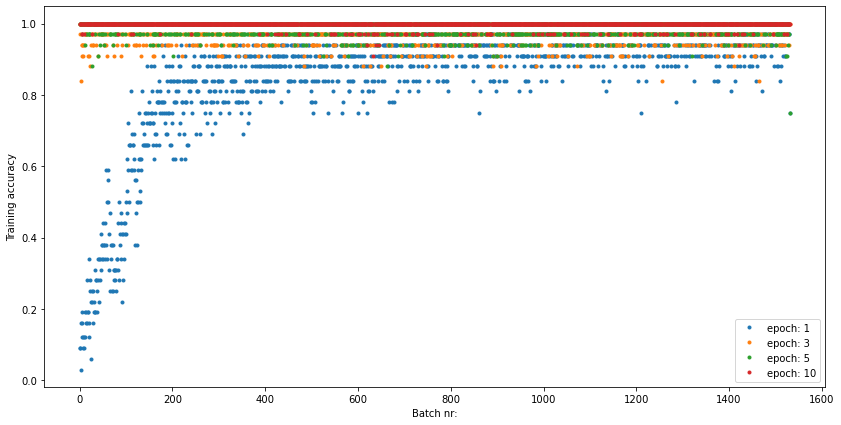

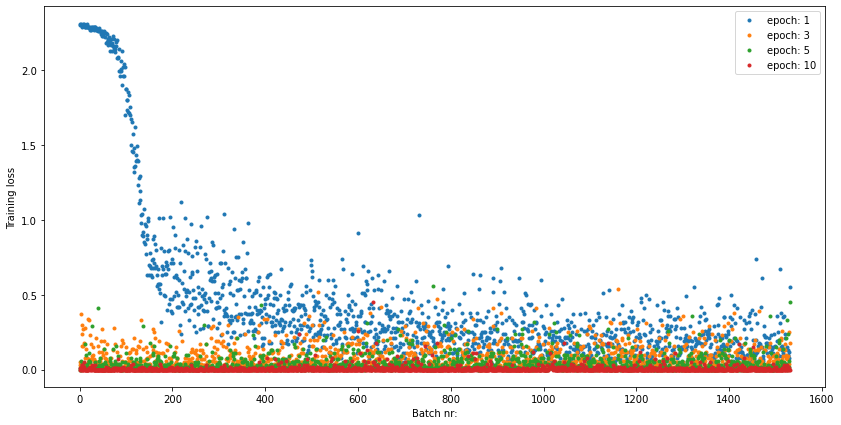


As seen in the plot the loss that occurs during training quickly decreases in the first 300 mini-batches.
Then a more steadily decrease thereafter. In the tenth epoch the loss is almost 0 (might be overfit slighly,
but still generalizes quite well).

The accuracy shares a similar pattern, though this plot has more distinct values of based on the batch-size (currently 32).
It is clear that after the 10th epoch the model gets results exceeding 90% accuracy 



In [17]:
plotHistory([1,3,5,10], history['training_acc'], 'Training accuracy')
plotHistory([1,3,5,10], history['training_loss'], 'Training loss')
print('''
As seen in the plot the loss that occurs during training quickly decreases in the first 300 mini-batches.
Then a more steadily decrease thereafter. In the tenth epoch the loss is almost 0 (might be overfit slighly,
but still generalizes quite well).

The accuracy shares a similar pattern, though this plot has more distinct values of based on the batch-size (currently 32).
It is clear that after the 10th epoch the model gets results exceeding 90% accuracy 
''')

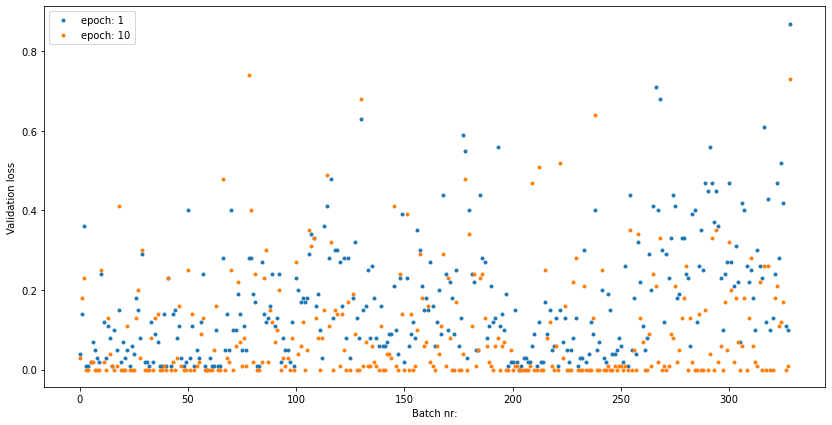


Interestingly the validation loss from the first and the last epoch are not that different. Im guessing this means the
model was able to generalize during the first epoch of training. It is however a improvement in mini-batches with almost
0 loss. It is clear that epoch 10 has much better results in that regard.



In [18]:
plotHistory([1,10], history['validation_loss'], 'Validation loss')
print('''
Interestingly the validation loss from the first and the last epoch are not that different. Im guessing this means the
model was able to generalize during the first epoch of training. It is however a improvement in mini-batches with almost
0 loss. It is clear that epoch 10 has much better results in that regard.
''')

In [19]:
# Please ignore :)) Just some random "hopefully useful code i would like to keep for later"

epoch = 1
training_loss_history = history['training_loss'][epoch]
training_acc_history  = history['training_acc'][epoch]
validation_loss_history = history['validation_loss'][epoch]
validation_acc_history = history['validation_acc'][epoch]
#print(training_loss_history)

# return xb.view(-1, xb.size(1))
#model_example = Network(input_size, hid1, hid2, hid3, output_size).to(dev)

#print(model)
#print(model_example)
#print(preprocessor(Image.open('MNIST/train/0/0.jpeg')).shape)
#print(preprocessor(Image.open('MNIST/train/0/0.jpeg')).view(batch_size,1,32,32).shape)

#print(model_example(preprocessor(Image.open('MNIST/train/0/0.jpeg')).view(32,-1).to(dev)))

#print(model_example(preprocessor(Image.open('MNIST/train/0/0.jpeg')).to(dev)))

out = model(preprocessor(Image.open('MNIST/test/9/100.jpeg')).to(dev))

confidences = torch.nn.functional.softmax(out, dim=1)[0]
percentages = confidences * 100
_, indices = torch.sort(out, descending=True)

values = list(map(lambda x: round(x,2),percentages.tolist()))

index_max = max(range(len(values)), key=values.__getitem__)

print(f"Prediction: {index_max}   Confidence: {max(values)}%")





Prediction: 9   Confidence: 99.96%
